In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context('poster')
import squarify  # pip install squarify
import random
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

### Reading data and Preprocessing 

This dataset contains recipes from different types of cuisines.
In this dataset it is included the recipe id, the type of cuisine, and the list of ingredients of each recipe. The data is stored in JSON format. (https://www.kaggle.com/c/whats-cooking-kernels-only/data)

In [2]:
data = pd.read_json('cooking.json')

In [3]:
data.shape

(39774, 3)

In [4]:
data.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [5]:
print('Number of documents:  {0}'.format(len(data)))
tokens = []
for i in range(len(data)):
    for j in range(len(data['ingredients'][i])):
        tokens.append(data['ingredients'][i][j])
print('Number of tokens:    {0}'.format(len(tokens)))
print('Number of types:       {0}'.format(len(set(tokens))))

Number of documents:  39774
Number of tokens:    428275
Number of types:       6714


In [6]:
ingredients_processed= []                                 # here we will store the preprocessed ingredients
for recipe in data['ingredients']:
    new_recipe = []
    for ingredient in recipe:
        ingredient.lower()                                # Case Normalization - convert all to lower case 
        ingredient = re.sub("[^a-zA-Z]"," ",ingredient)   # Remove punctuation, digits or special characters 
        ingredient = re.sub((r'\b(oz|ounc|ounce|pound|lb|inch|inches|kg|to)\b'), ' ', ingredient)      # Remove different units  
        new_recipe.append(ingredient)
    ingredients_processed.append(new_recipe)
data['ingredients'] = ingredients_processed

In [7]:
print('Number of documents:  {0}'.format(len(data)))
len(ingredients_processed)
tokens_processed = []
for i in range(len(ingredients_processed)):
    for j in range(len(ingredients_processed[i])):
        tokens_processed.append(ingredients_processed[i][j])
print('Number of tokens:    {0}'.format(len(tokens_processed)))
print('Number of types:       {0}'.format(len(set(tokens_processed))))

Number of documents:  39774
Number of tokens:    428275
Number of types:       6709


The number of types is reduced by 5.

### Analysis 

The goal of this analysis is to explore and visualize the data. More specifically we want to know what are the most common, the unique and the most important ingredients in recipes of different cuisines.

### Taking a look at cuisines and ingredients represented in this data set 

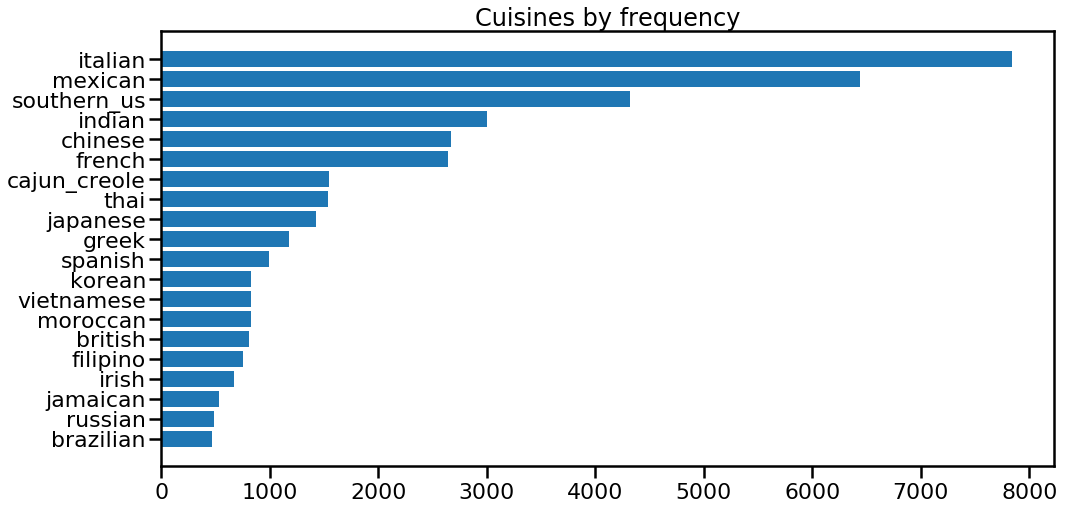

In [8]:
plt.figure(figsize=(16,8))
plt.barh(data['cuisine'].value_counts().index[::-1], data['cuisine'].value_counts().values[::-1])
plt.title('Cuisines by frequency')
print()

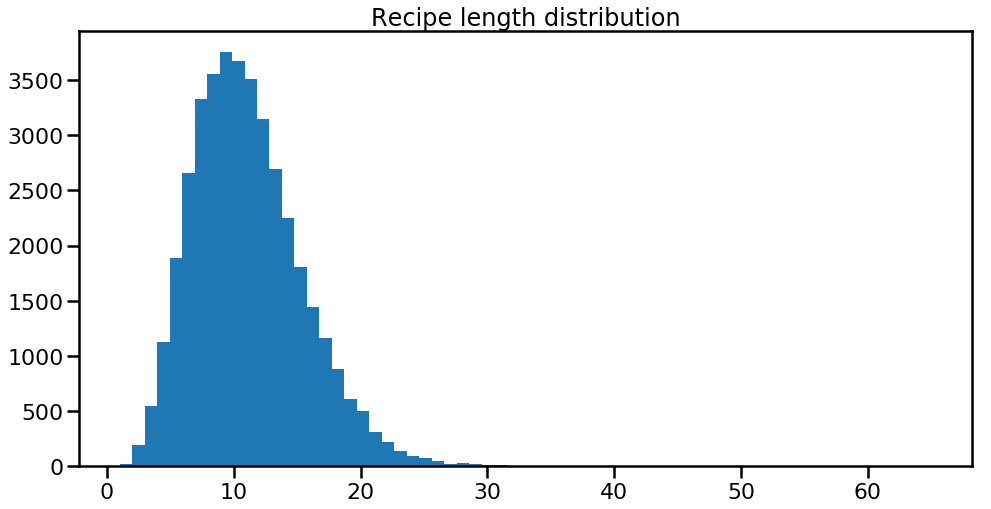

In [9]:
plt.figure(figsize=(16,8))
plt.hist(data['ingredients'].str.len().values, bins = 65)
plt.title('Recipe length distribution')
print()

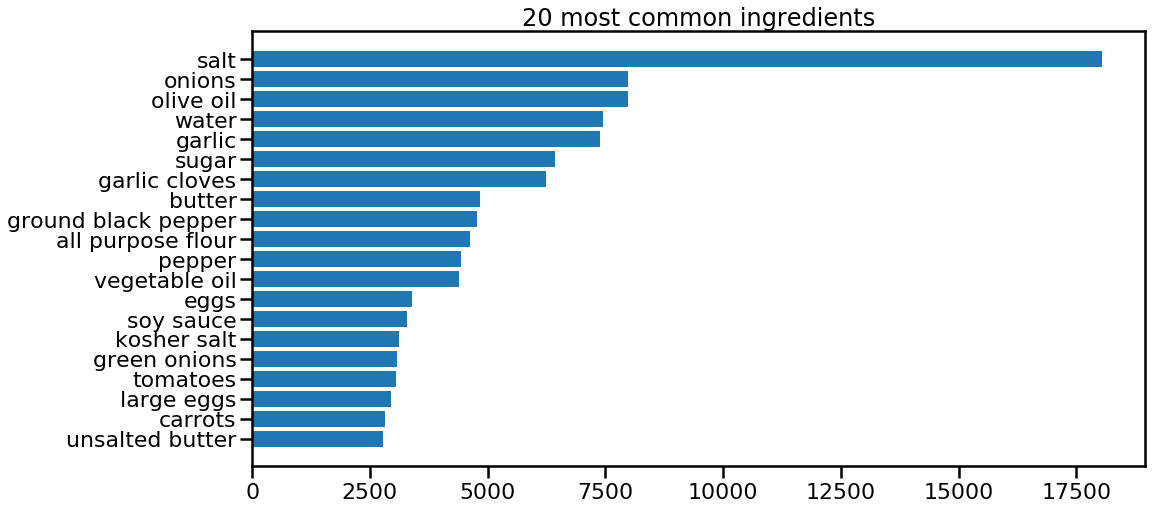

In [10]:
all_ingredients = []
for recipe in data['ingredients']:
    for ingredient in recipe:
        all_ingredients.append(ingredient) 
        
counter = Counter()
for ingredient in all_ingredients:
     counter[ingredient] += 1
        
top_20 = pd.DataFrame(counter.most_common(20), columns = ['ingredient','count'])

plt.figure(figsize=(16,8))
plt.barh(top_20['ingredient'][::-1], top_20['count'][::-1])
plt.title('20 most common ingredients')
print()

### Barcharts for top 5 ingredients used by different cuisines

In [11]:
labels = [i for i in data.cuisine.value_counts().index]

#### Top 5 overall ingredients

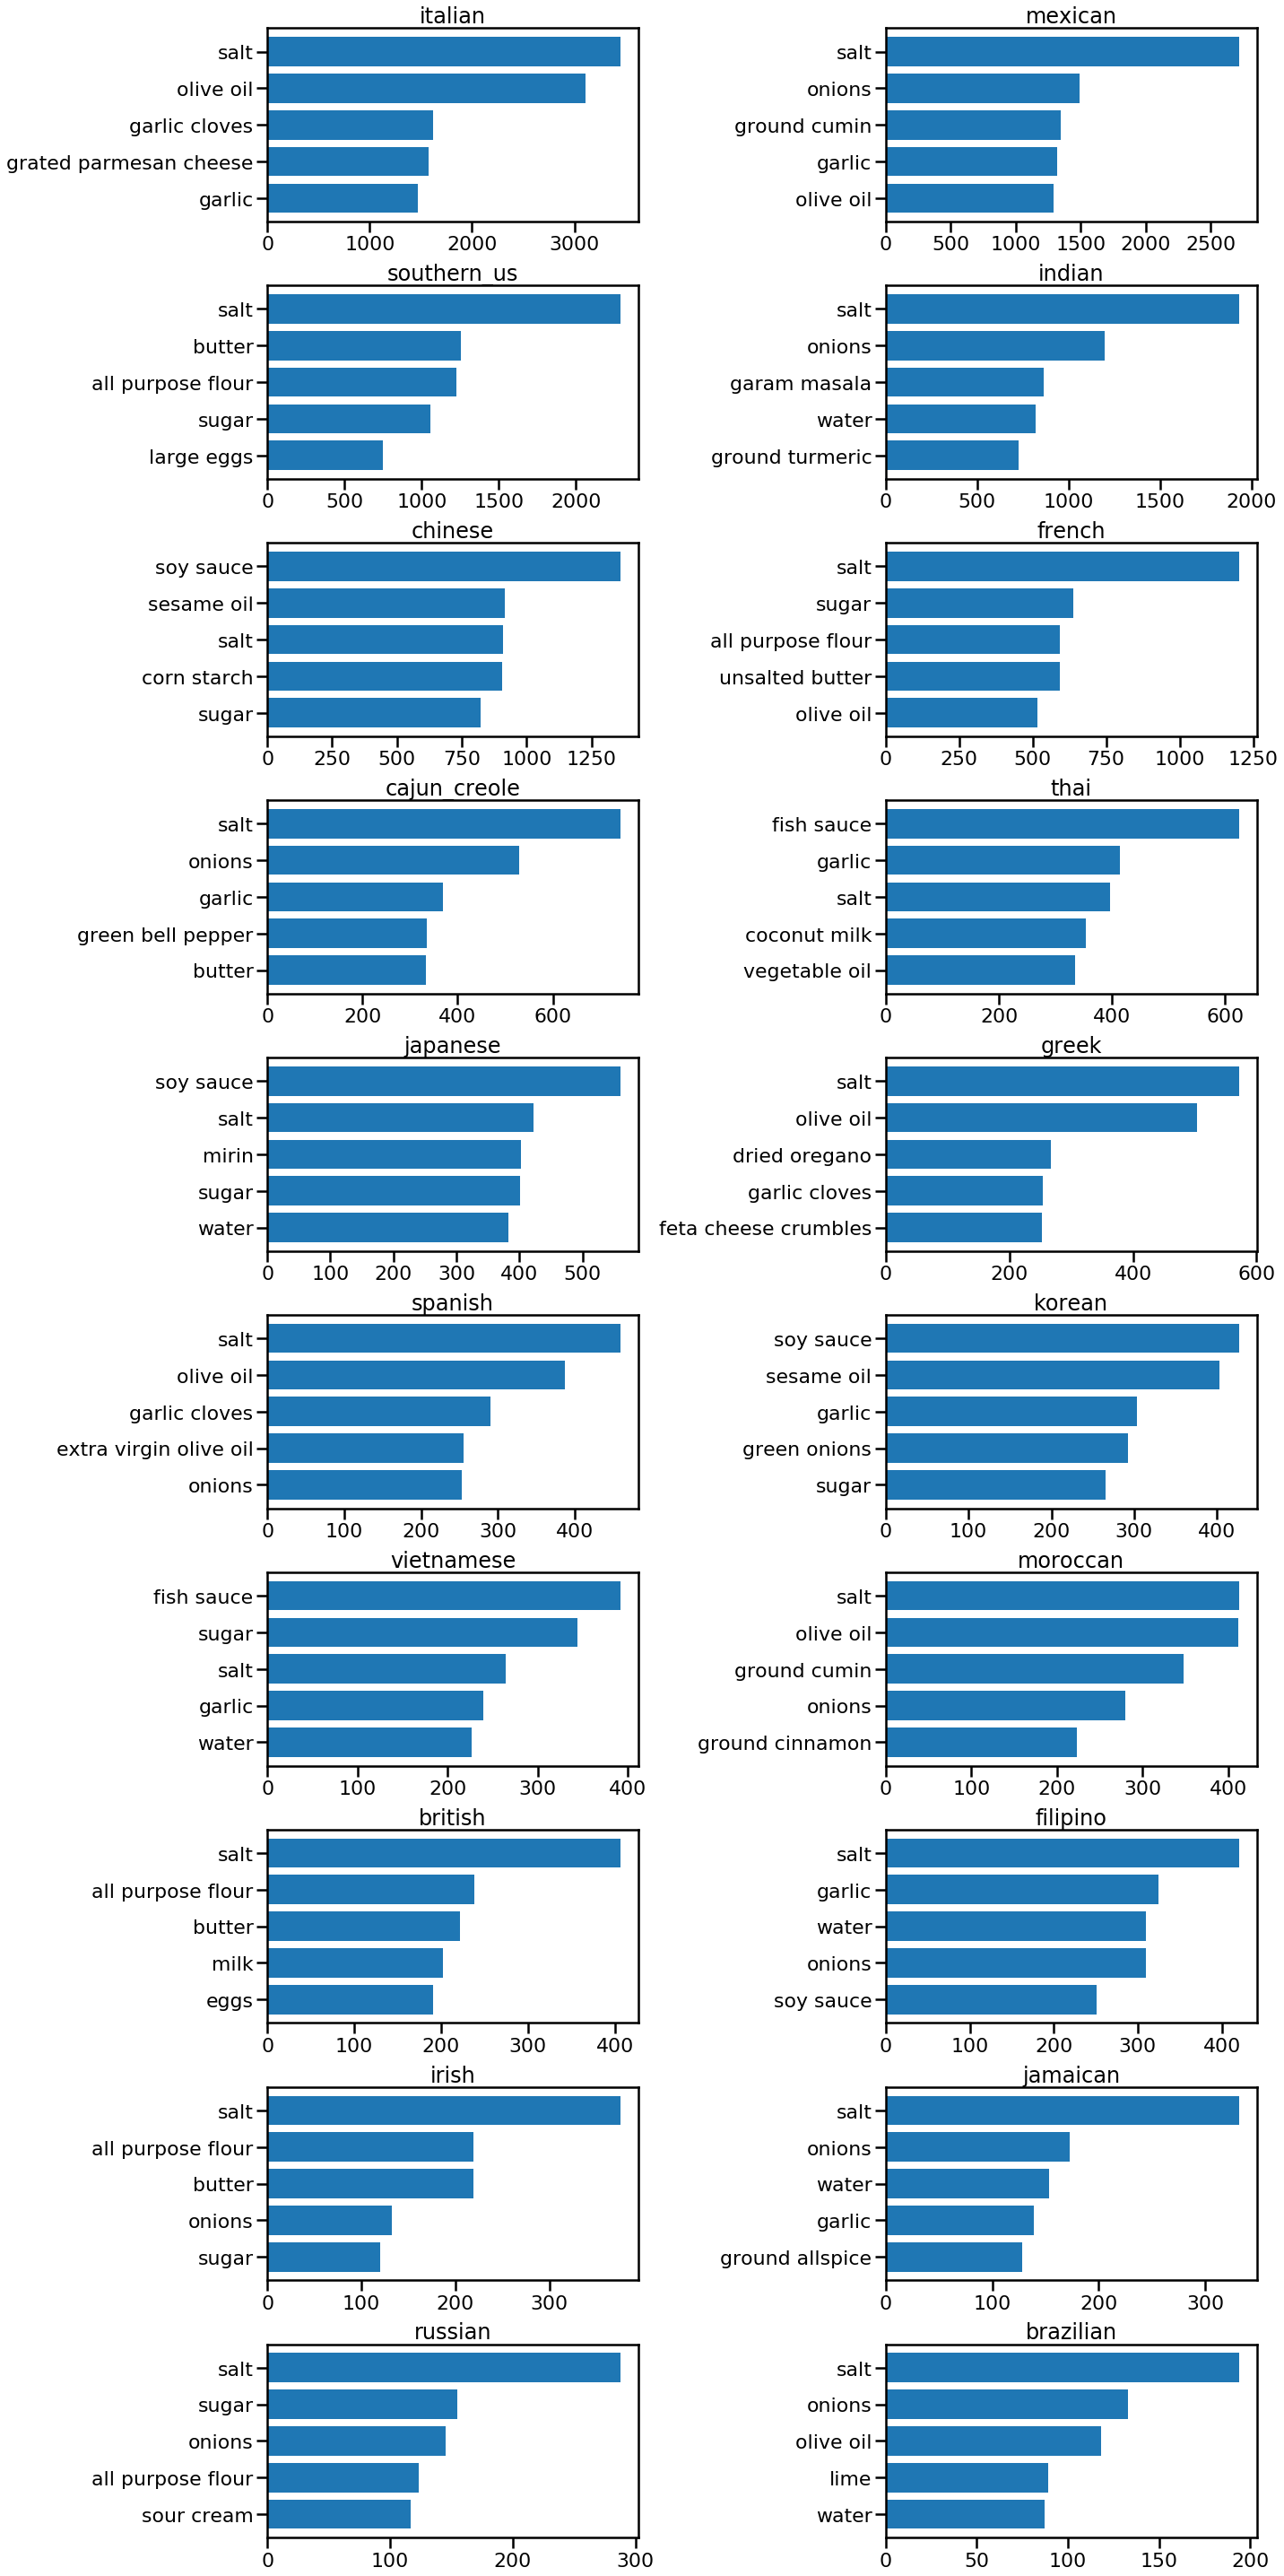

In [12]:
fig, axes = plt.subplots(10, 2, figsize=(20, 40))
ax = axes.ravel()

for i in range(len(labels)):
    ingredients = []
    ids = data['cuisine'] == labels[i]
    for recipe in data[ids]['ingredients']:
        for ingr in recipe:
            ingredients.append(ingr)
            
    counter = Counter()
    for ingr in ingredients:
         counter[ingr] += 1
    
    top_5 = pd.DataFrame(counter.most_common(5), columns = ['ingredient','count'])
    ax[i].barh(top_5['ingredient'][::-1], top_5['count'][::-1])
    ax[i].set_title(labels[i])
    fig.tight_layout()

#### Top 5 unique ingredients 

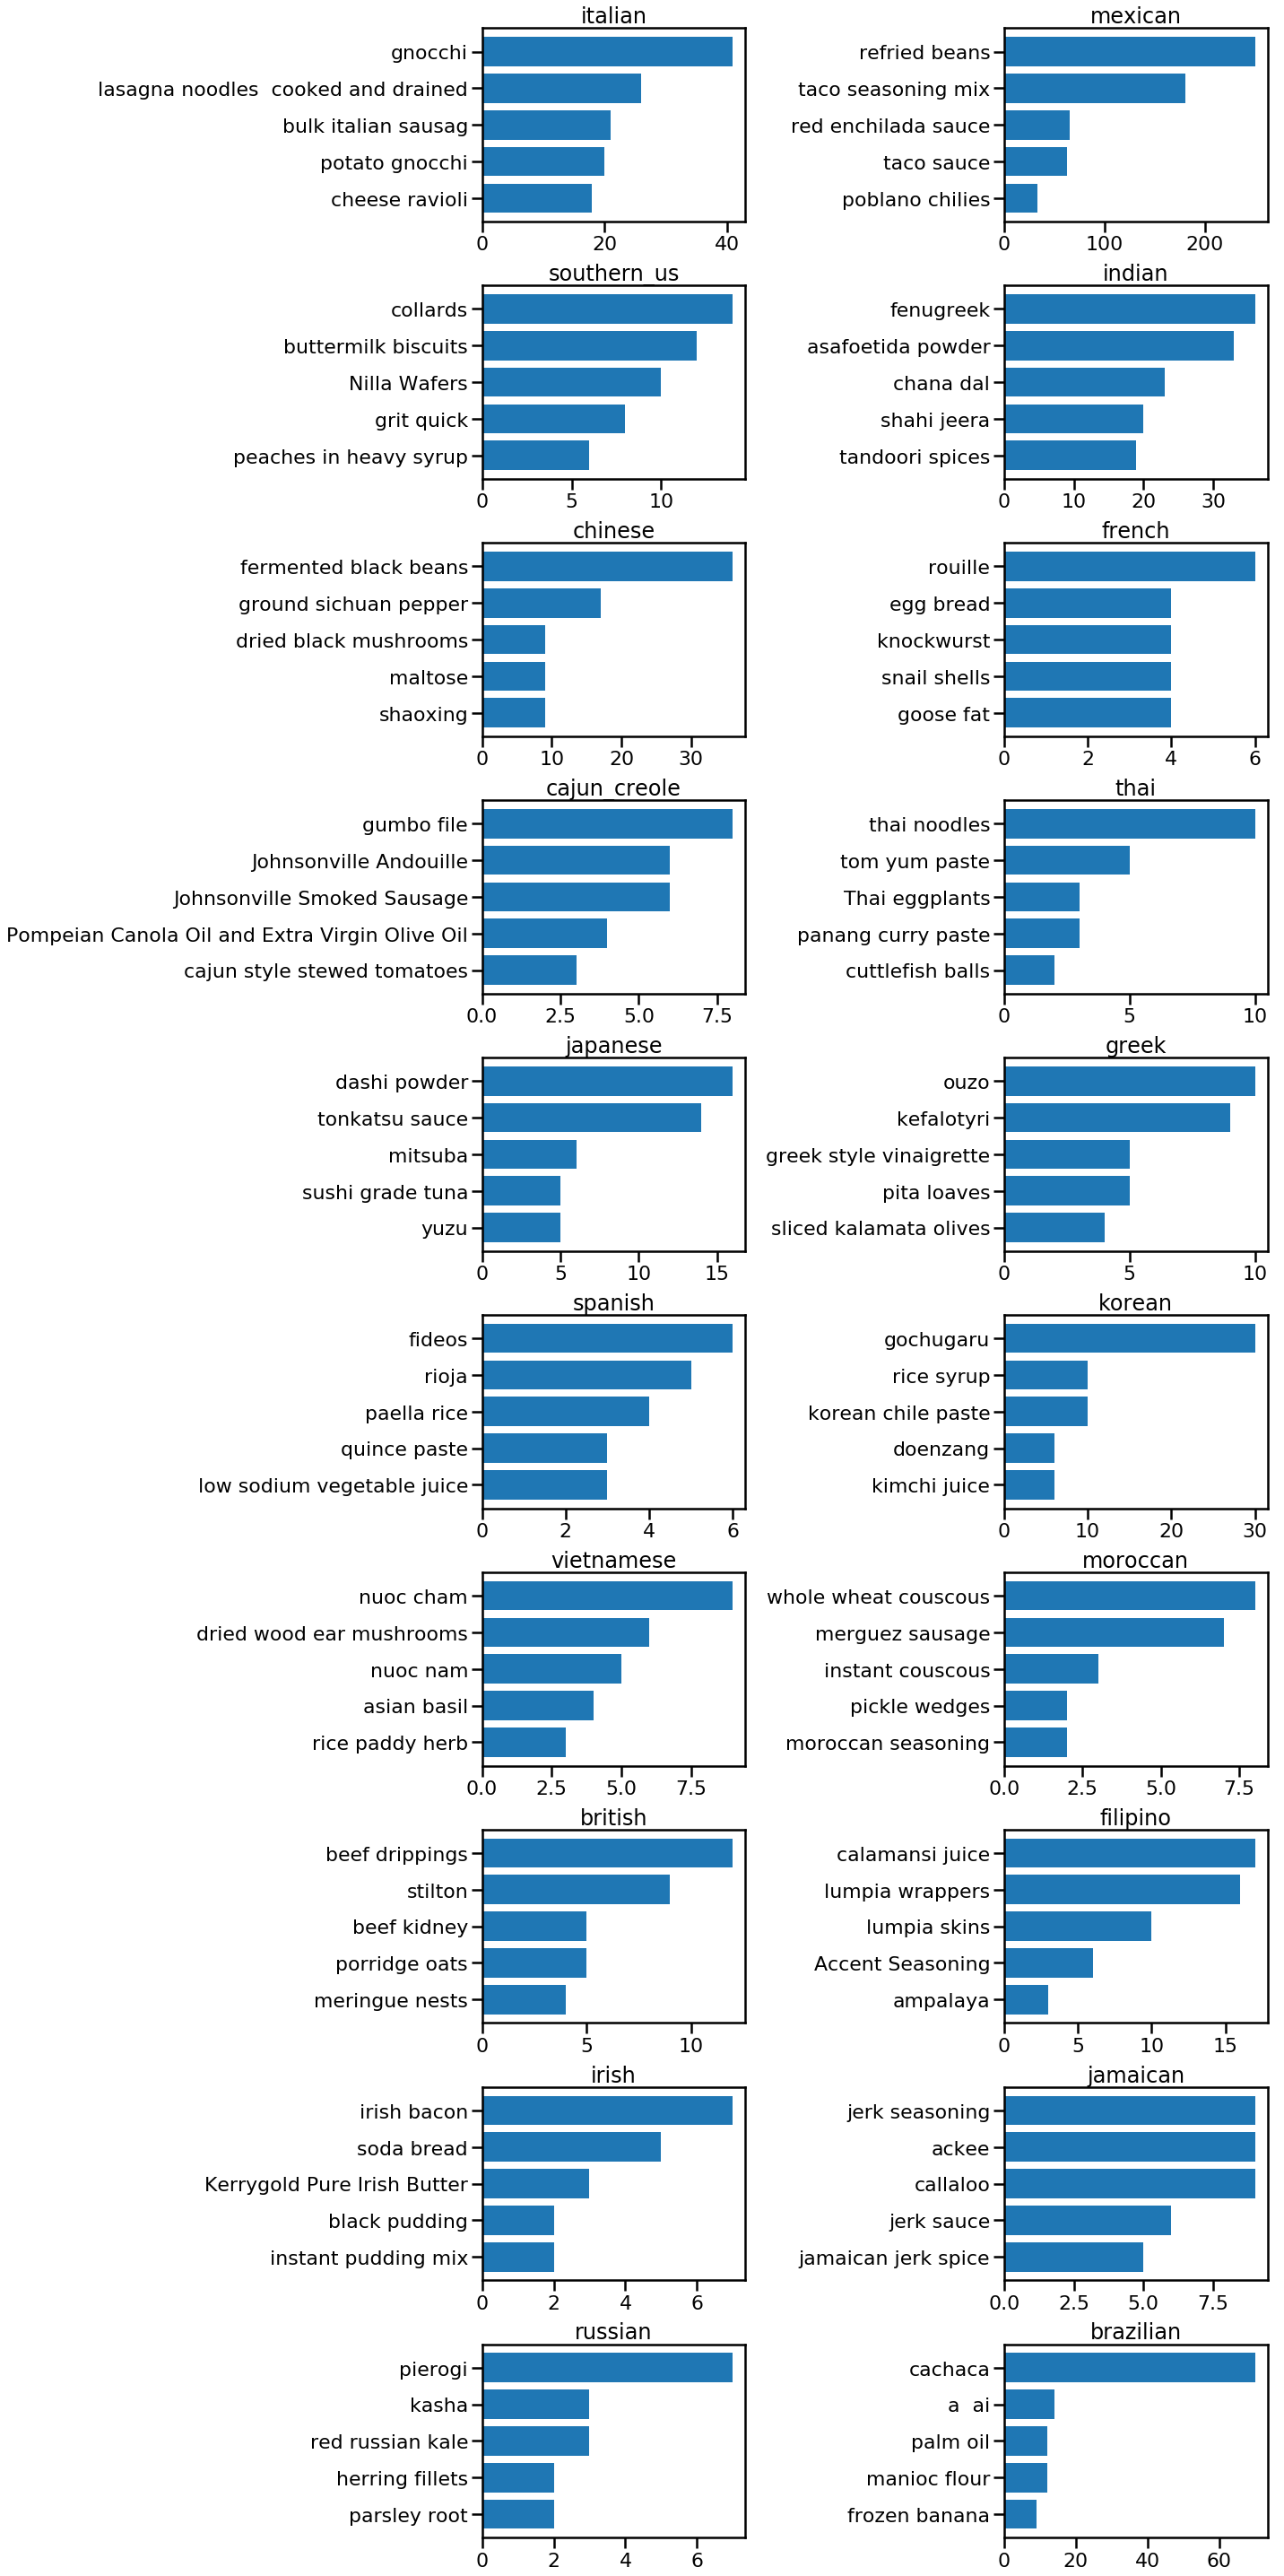

In [13]:
fig, axes = plt.subplots(10, 2, figsize=(20, 40))
ax = axes.ravel()

for i in range(len(labels)):

    all_other_ingredients = []
    for recipe in data[data.cuisine != labels[i]]['ingredients']:
        for ingredient in recipe:
            all_other_ingredients.append(ingredient)
    all_other_ingredients = list(set(all_other_ingredients))
    
    all_ingredients = list(set(all_ingredients))
    
    unique_ingredients = [i for i in all_ingredients if i not in all_other_ingredients]
    
    counter = Counter()
    for recipe in data[data.cuisine == labels[i]]['ingredients']:
        for ingredient in recipe:
            if ingredient in unique_ingredients:
                counter[ingredient] += 1
                
    top_5 = pd.DataFrame(counter.most_common(5), columns = ['ingredient','count'])
    ax[i].barh(top_5['ingredient'][::-1], top_5['count'][::-1])
    ax[i].set_title(labels[i])
    fig.tight_layout()

#### Top 5 most important ingredients by tfidf score 

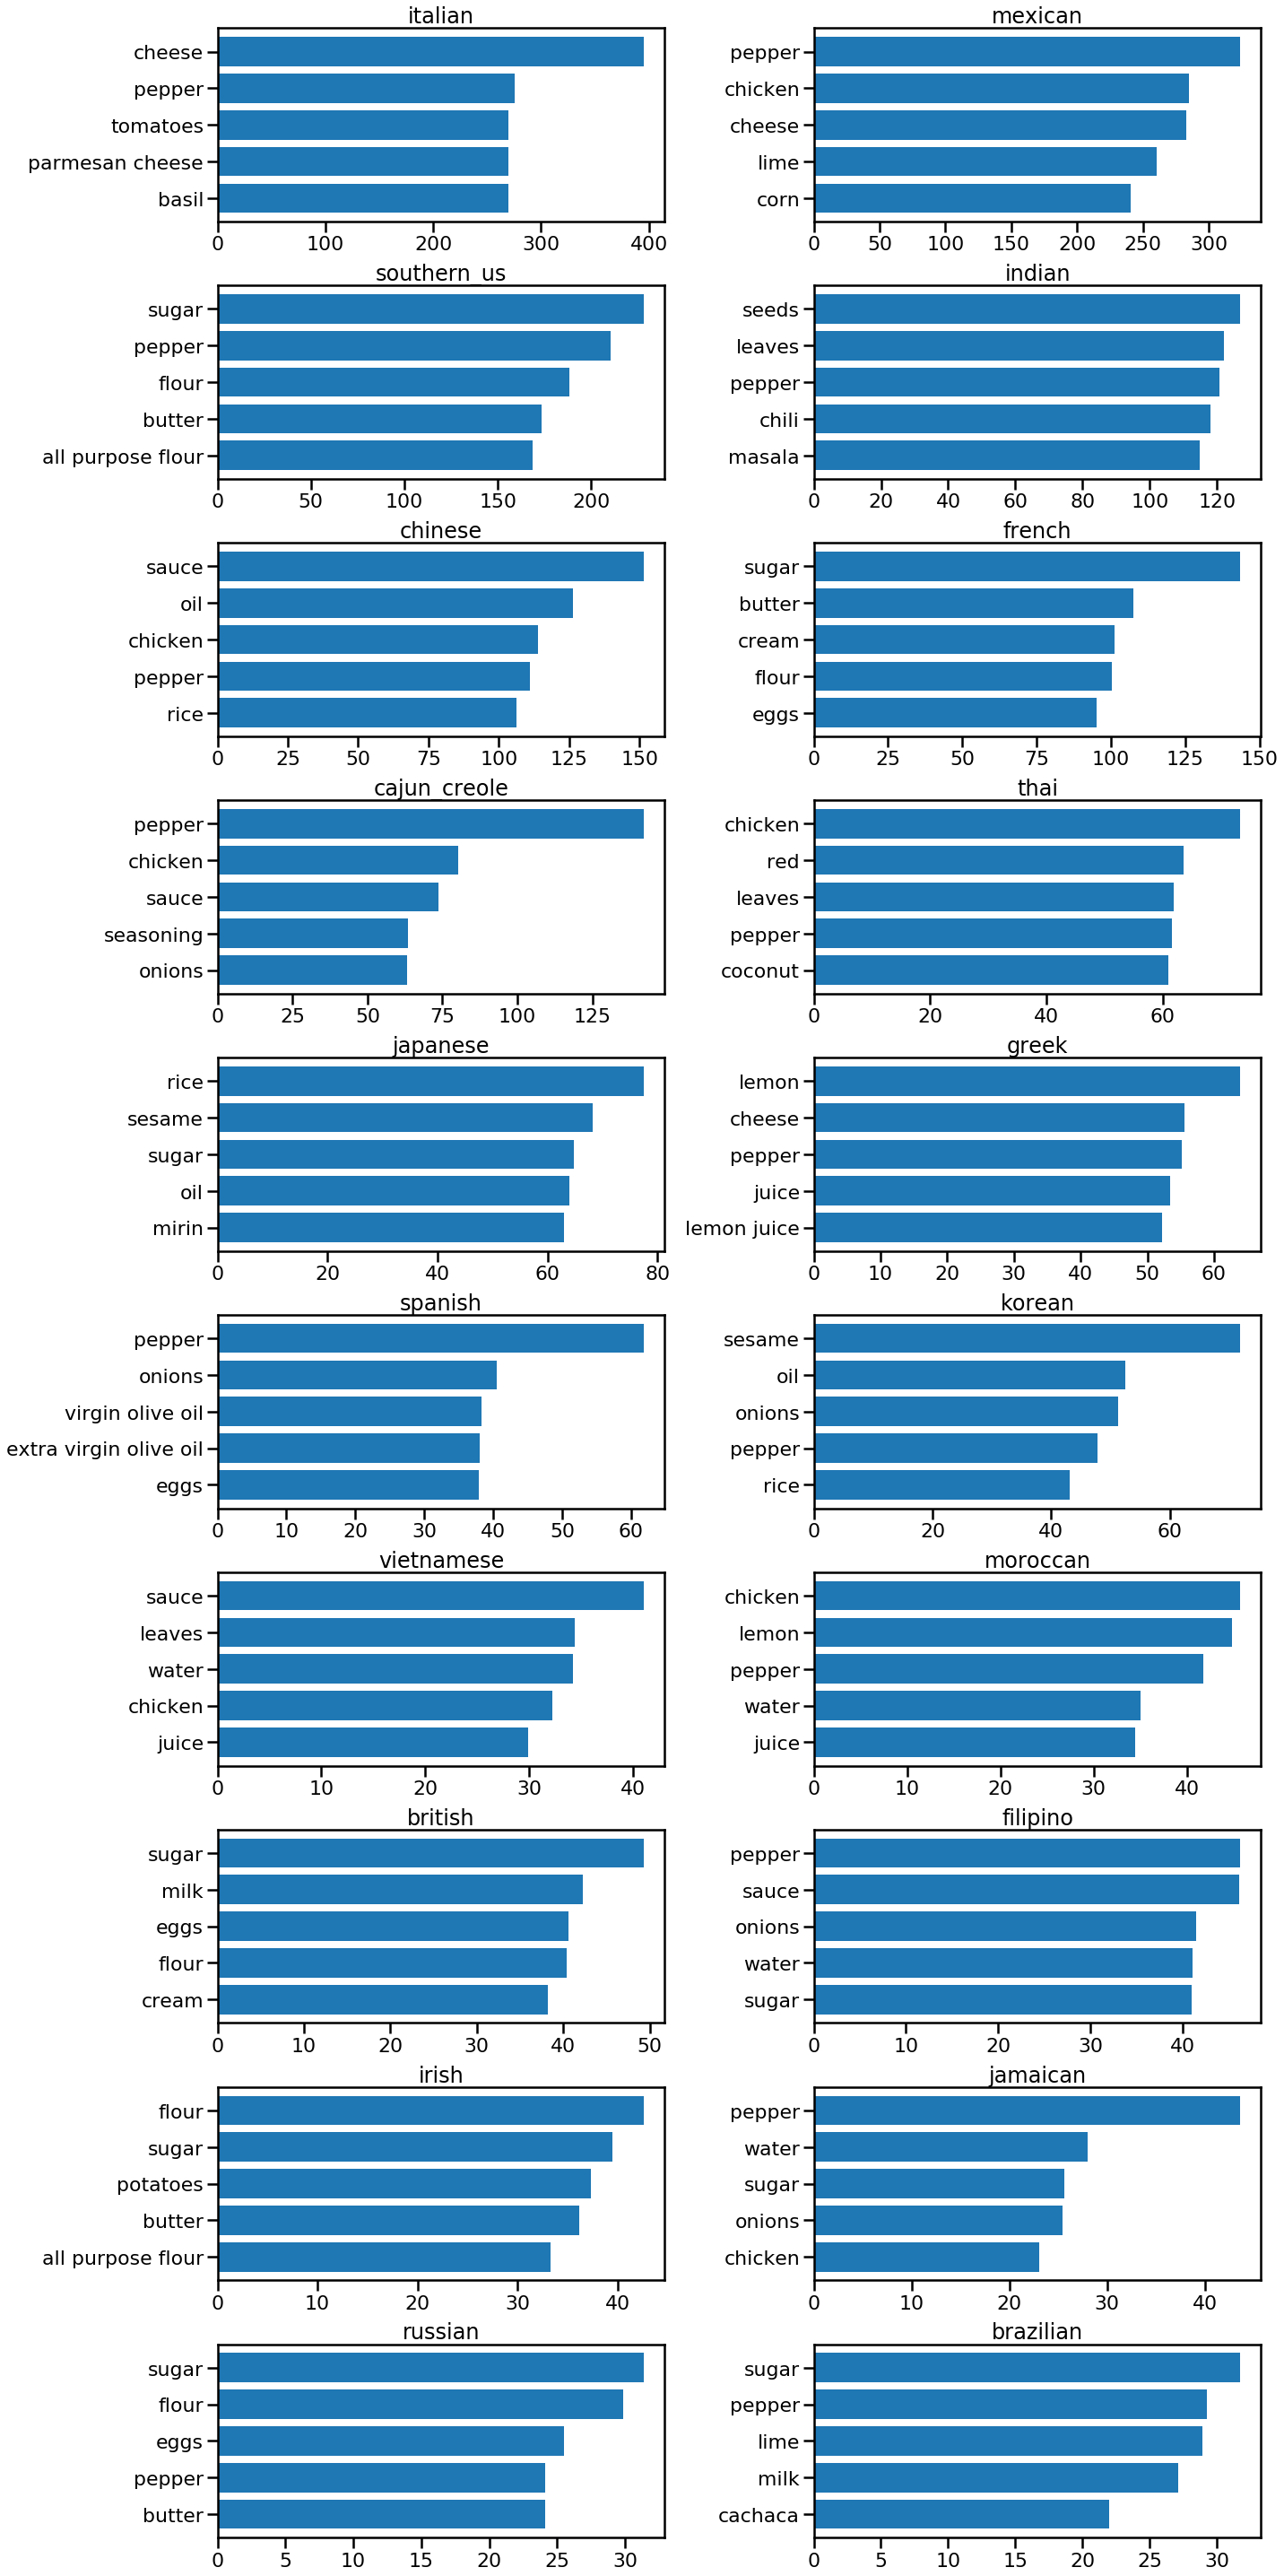

In [14]:
fig, axes = plt.subplots(10, 2, figsize=(20, 40))
ax = axes.ravel()

for i in range(len(labels)):

    ids = data['cuisine'] == labels[i]
    documents = data[ids].ingredients.values
    
    vocabulary = []
    for j in range(len(documents)):
        for k in range(len(documents[j])):
            vocabulary.append(documents[j][k])
    vocabulary = list(set(vocabulary))
    
    X = []
    for j in range(len(documents)):
        x = ''
        for k in (documents[j]):
            x += k + ' '
        X.append(x)
    
    tfidf_vectorizer = TfidfVectorizer(vocabulary= vocabulary, min_df=0.001, max_df=0.75, ngram_range=(1, 4))
    X = tfidf_vectorizer.fit_transform(X)
    
    word_tfidf = X.toarray()
    word_tfidf[word_tfidf < 0.1] = 0

    df = pd.DataFrame(data={'word': tfidf_vectorizer.get_feature_names(),
                            'tfidf': word_tfidf.sum(axis=0)
                           })
    top_5 = df.sort_values(['tfidf'], ascending=False).head(5)
    ax[i].barh(top_5['word'][::-1], top_5['tfidf'][::-1])
    ax[i].set_title(labels[i])
    fig.tight_layout()

### Treemaps for top 5 ingredients used by different cuisines 

#### Top 5 ingredients overall 

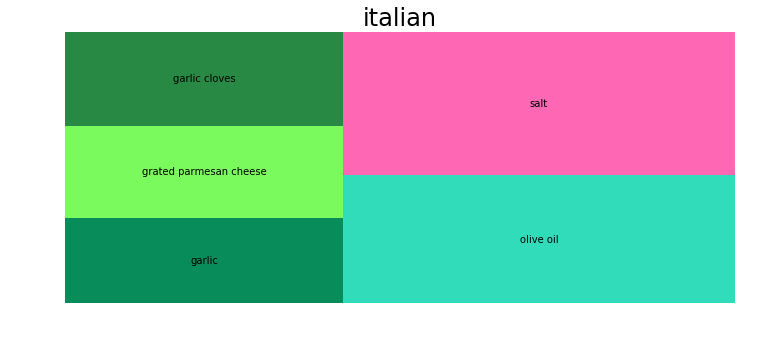

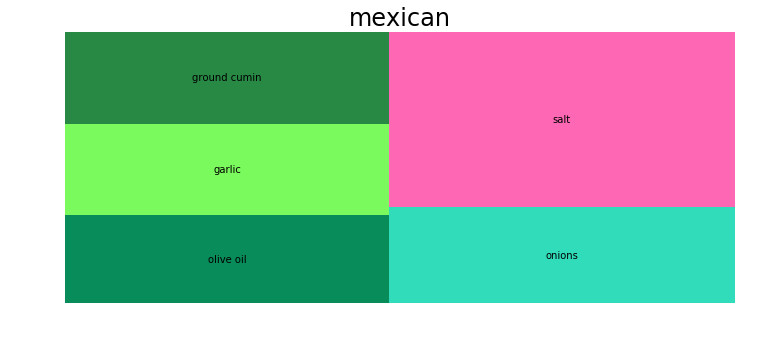

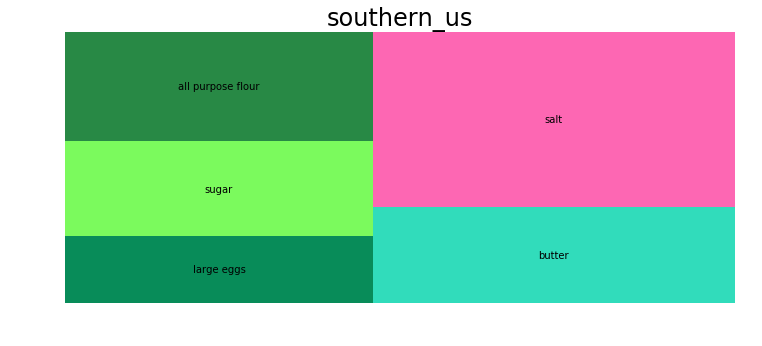

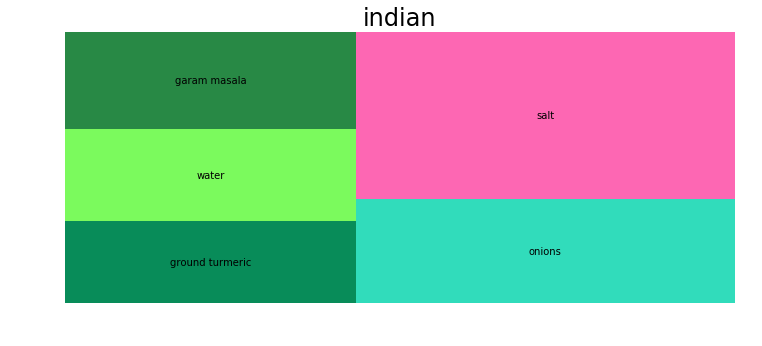

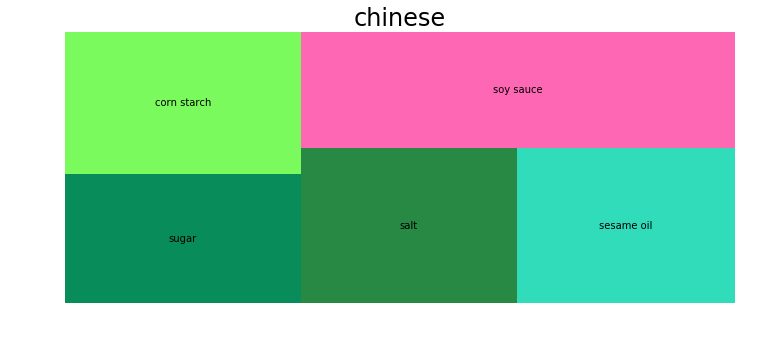

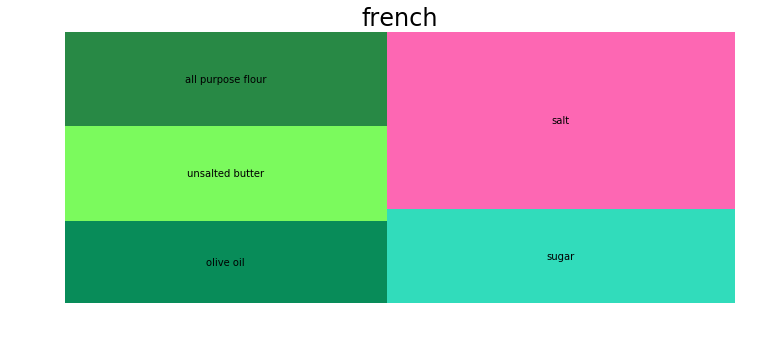

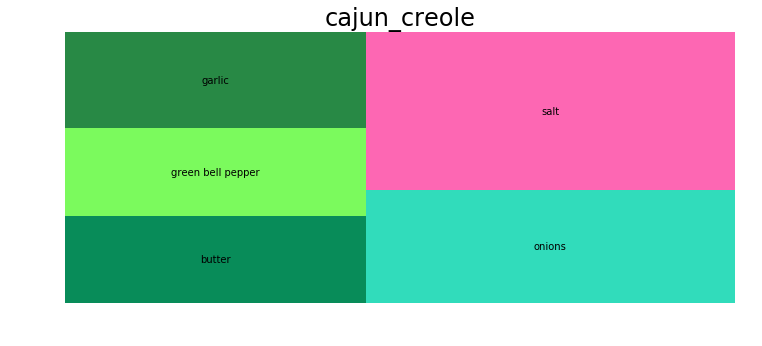

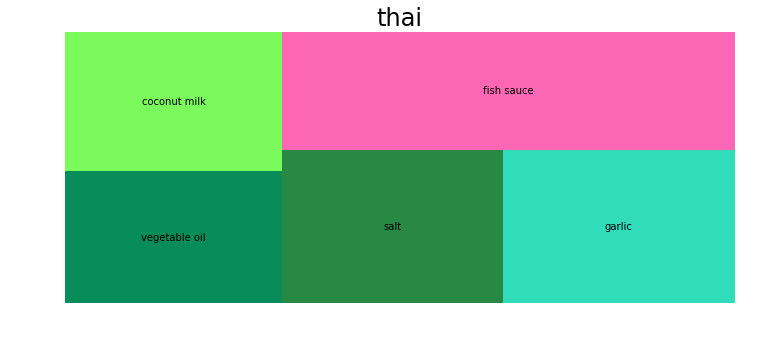

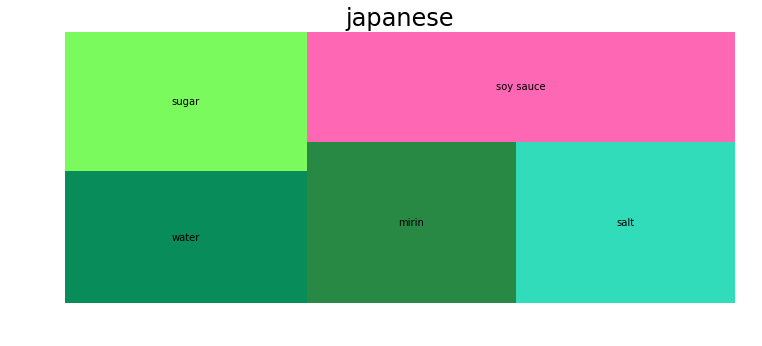

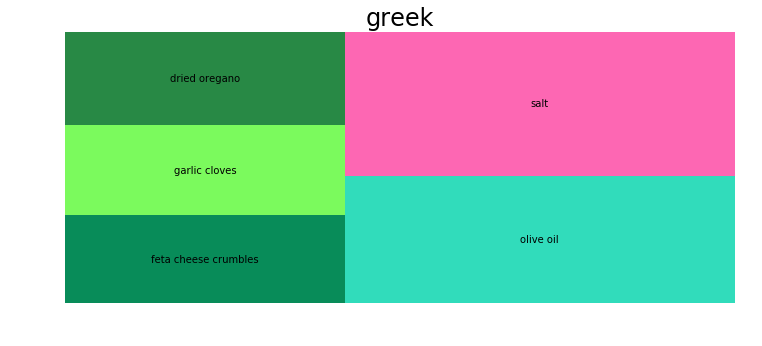

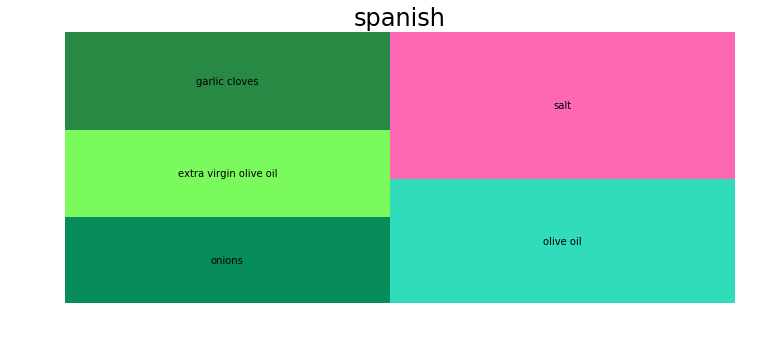

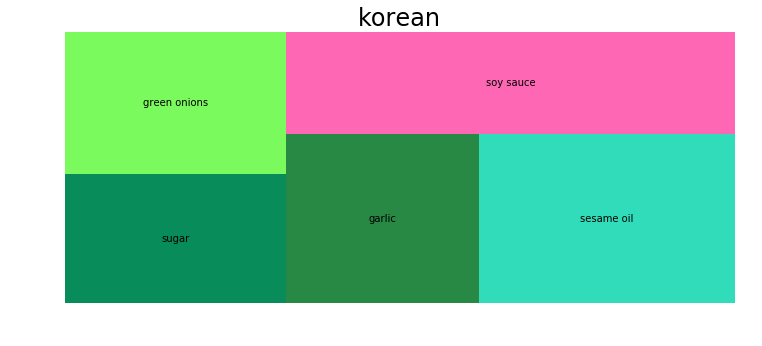

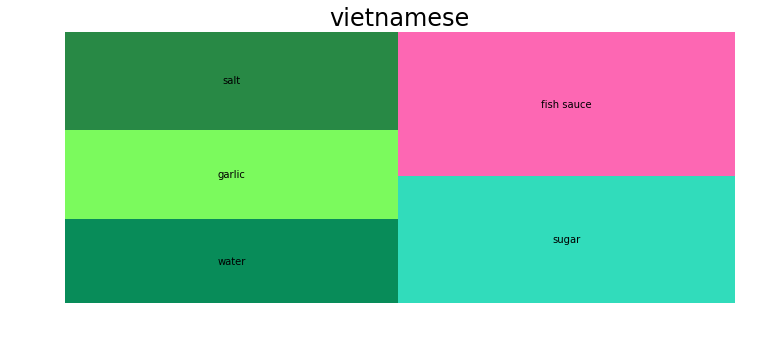

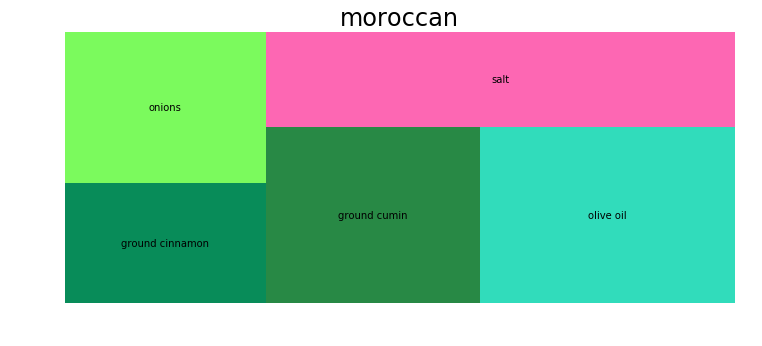

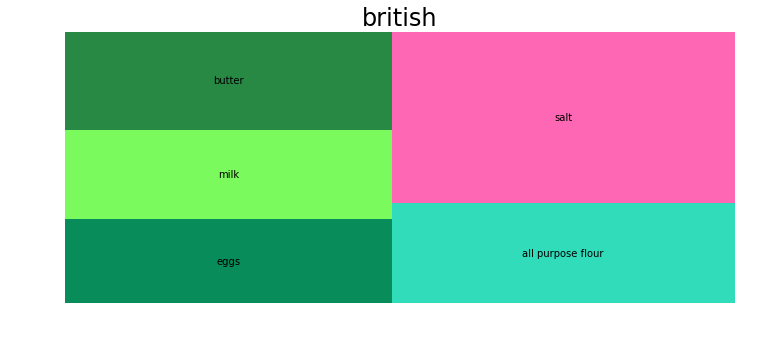

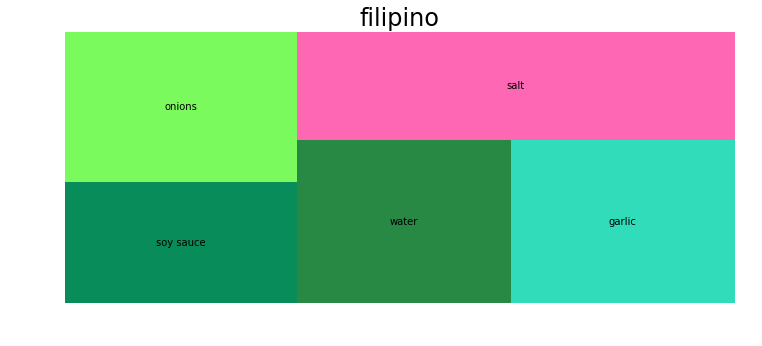

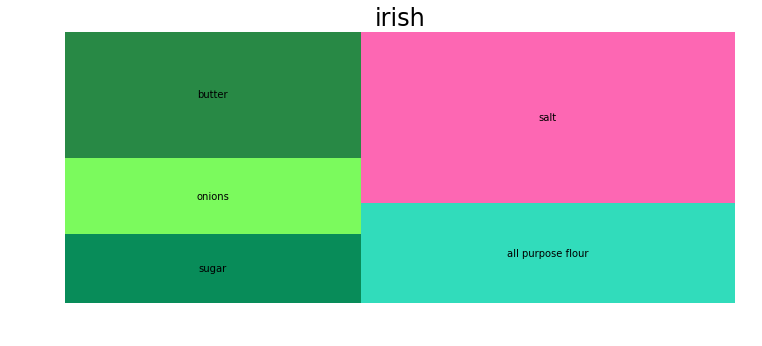

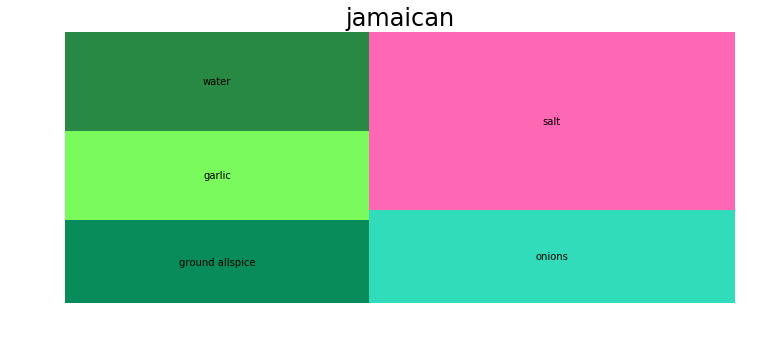

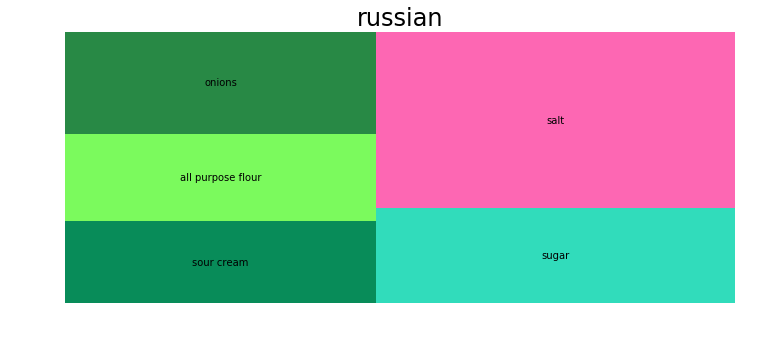

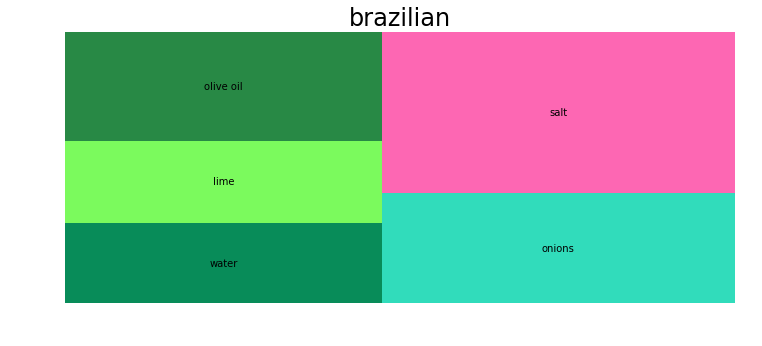

In [15]:
colors = []
for i in range(10):
    colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    
for i in range(len(labels)):
    ingredients = []
    ids = data['cuisine'] == labels[i]
    for recipe in data[ids]['ingredients']:
        for ingr in recipe:
            ingredients.append(ingr)
            
    counter = Counter()
    for ingr in ingredients:
         counter[ingr] += 1
    
    top_5 = pd.DataFrame(counter.most_common(5), columns = ['ingredient','count'])
    plt.figure(figsize=(12, 5))
    plt.title(labels[i])
    squarify.plot(label = top_5['ingredient'][::-1], sizes = top_5['count'][::-1], color=colors)
    plt.axis('off')
    plt.show()

#### Top 5 unique ingredients 

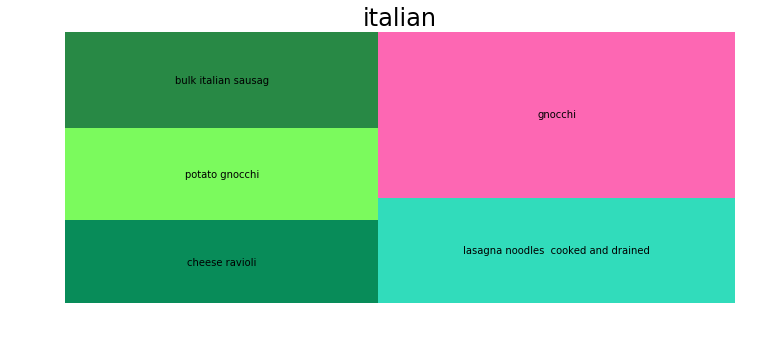

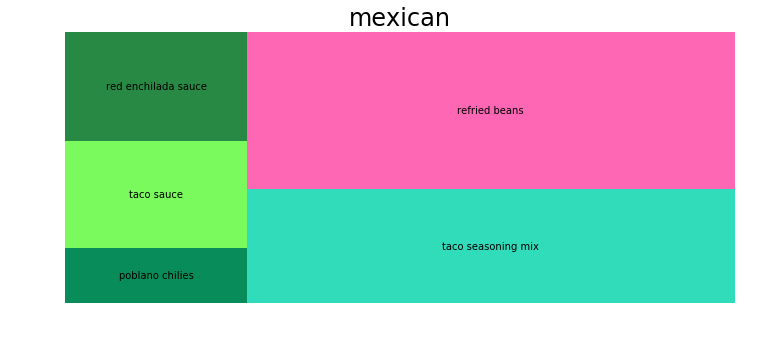

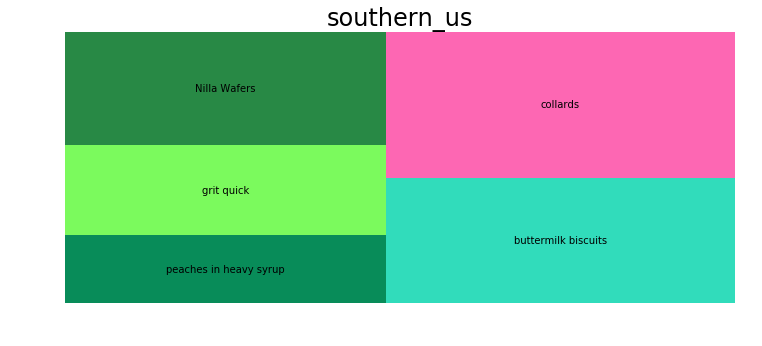

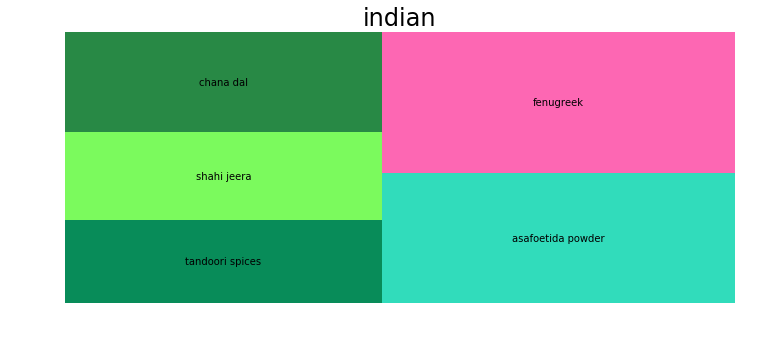

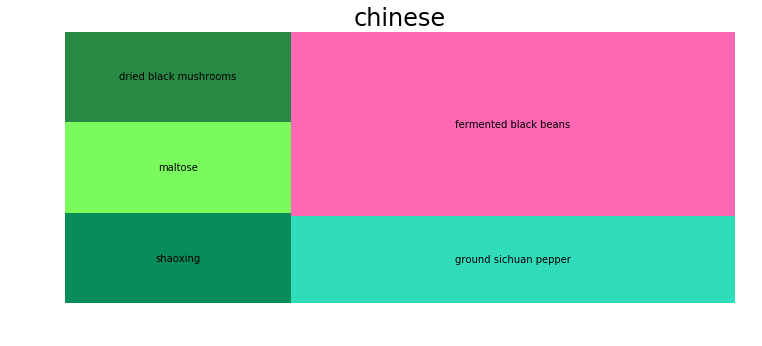

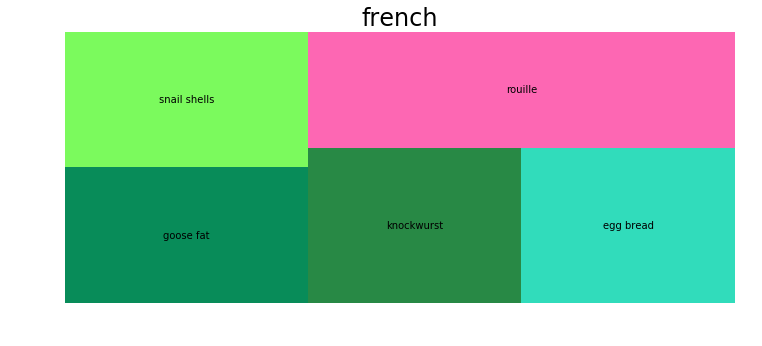

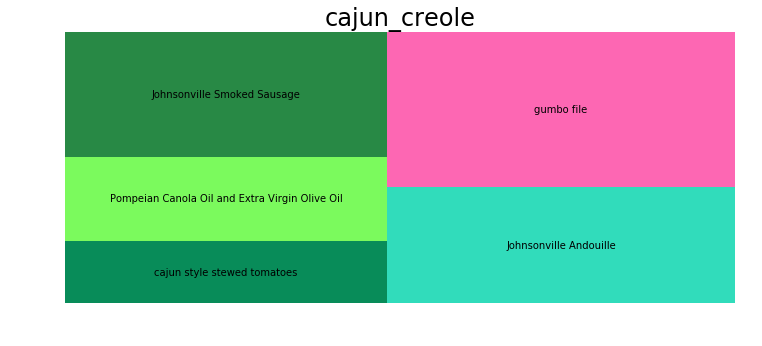

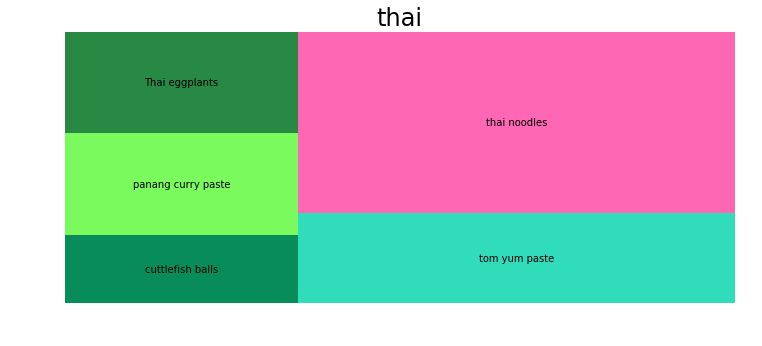

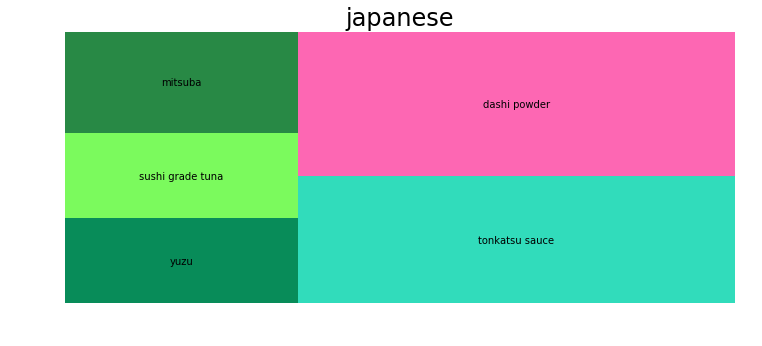

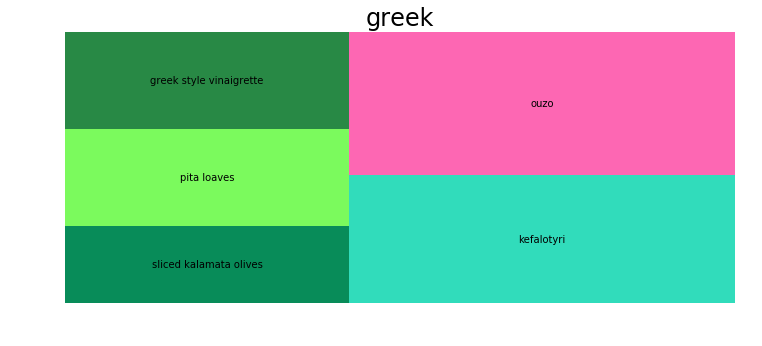

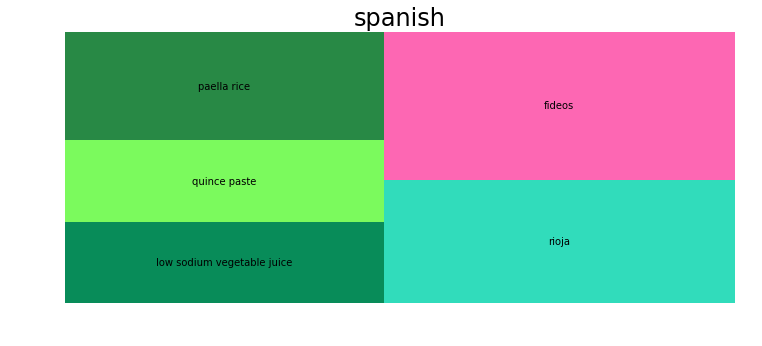

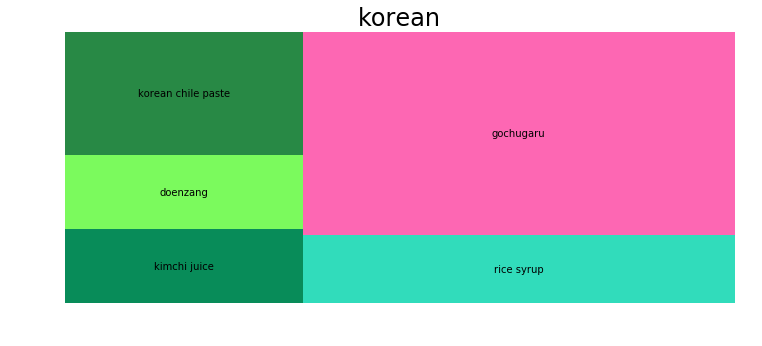

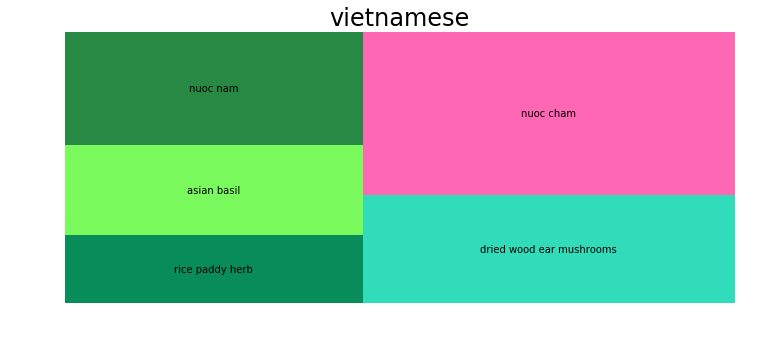

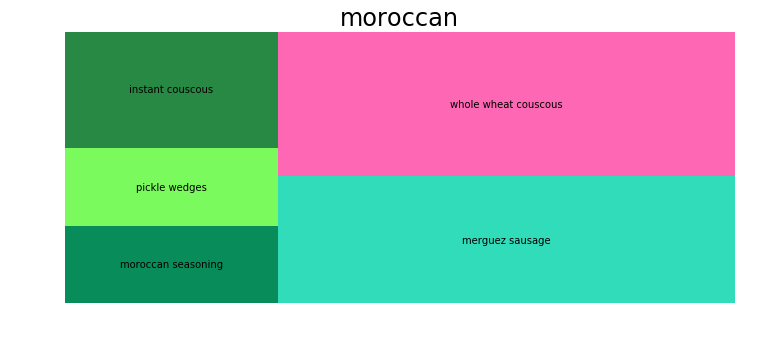

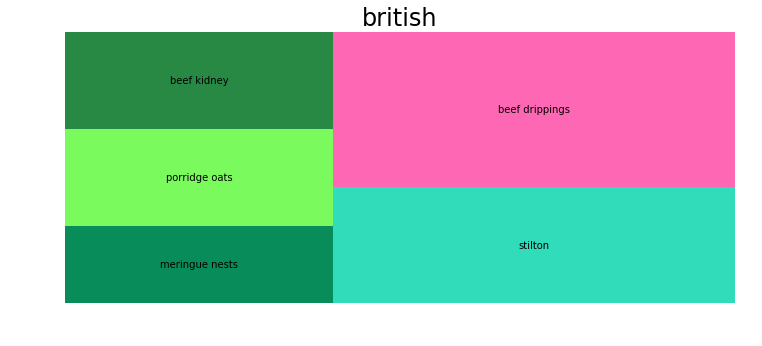

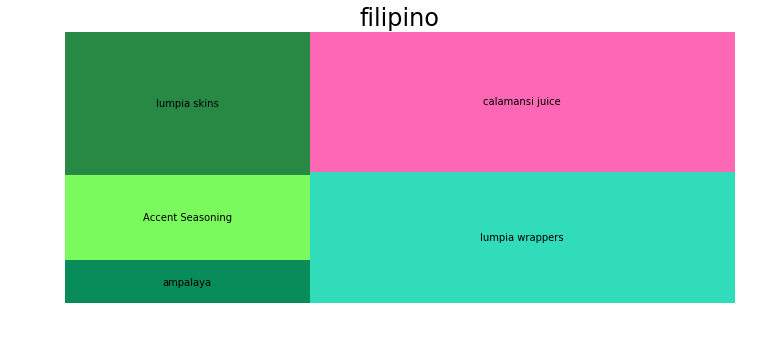

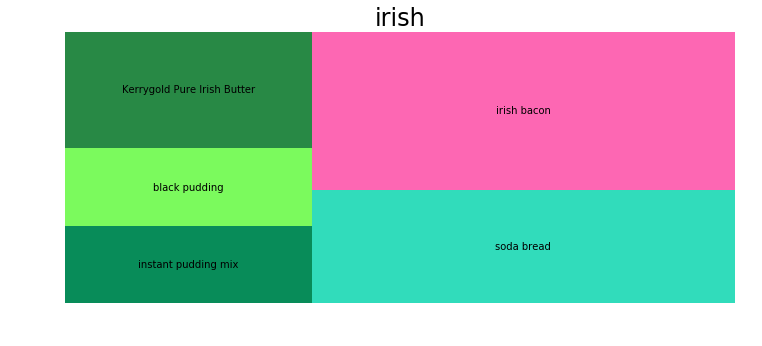

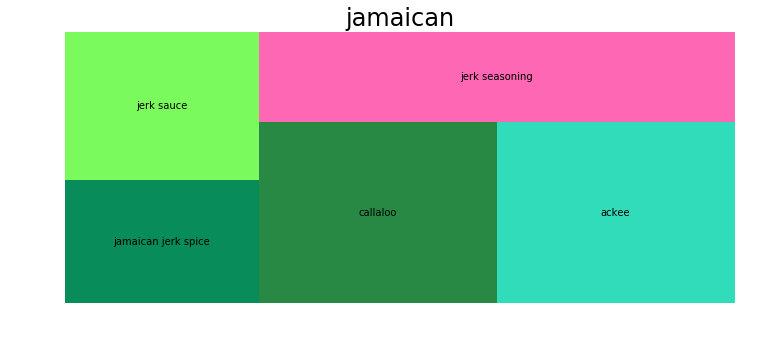

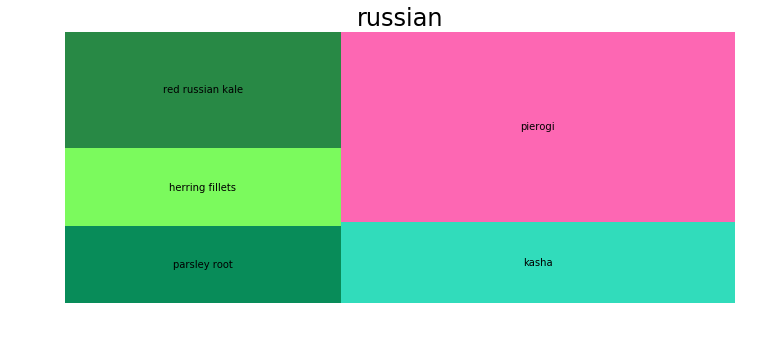

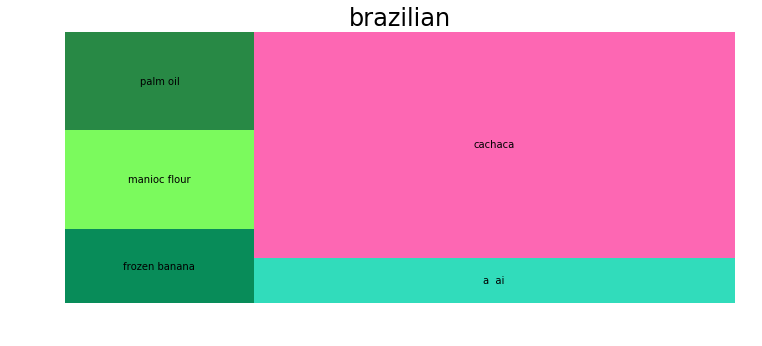

In [16]:
for i in range(len(labels)):

    all_other_ingredients = []
    for recipe in data[data.cuisine != labels[i]]['ingredients']:
        for ingredient in recipe:
            all_other_ingredients.append(ingredient)
    all_other_ingredients = list(set(all_other_ingredients))
    
    unique_ingredients = [i for i in all_ingredients if i not in all_other_ingredients]
    
    counter = Counter()
    for recipe in data[data.cuisine == labels[i]]['ingredients']:
        for ingredient in recipe:
            if ingredient in unique_ingredients:
                counter[ingredient] += 1
                
    top_5 = pd.DataFrame(counter.most_common(5), columns = ['ingredient','count'])
    plt.figure(figsize=(12, 5))
    plt.title(labels[i])
    squarify.plot(label = top_5['ingredient'][::-1], sizes = top_5['count'][::-1], color=colors)
    plt.axis('off')
    plt.show()

#### Top 5 most important ingredients by tfidf score 

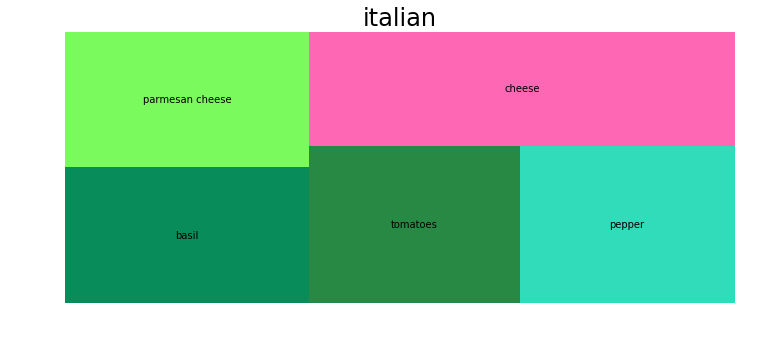

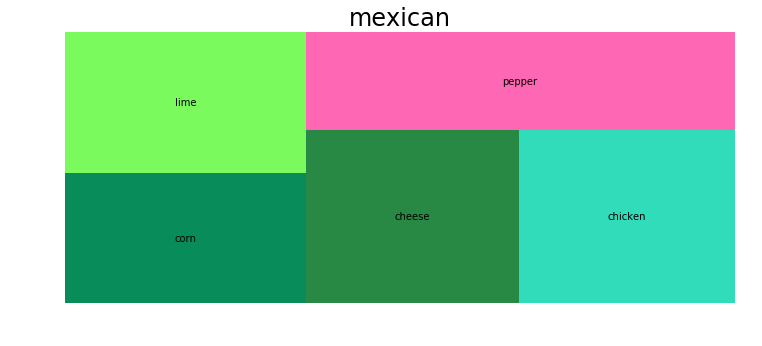

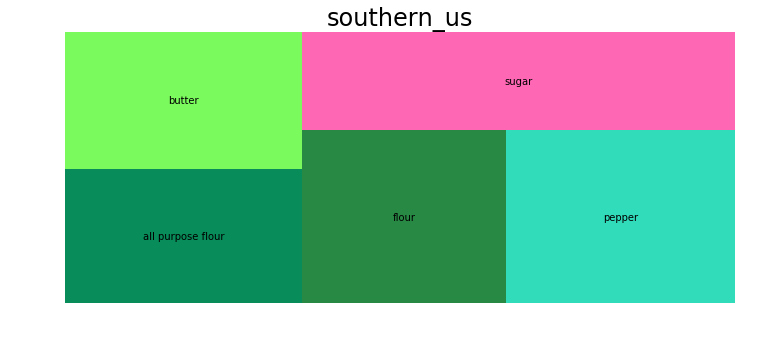

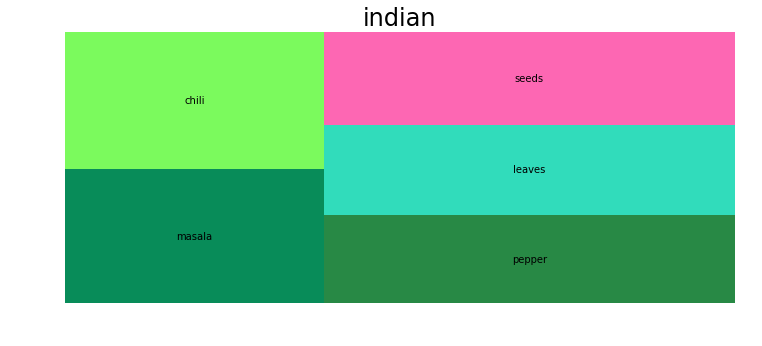

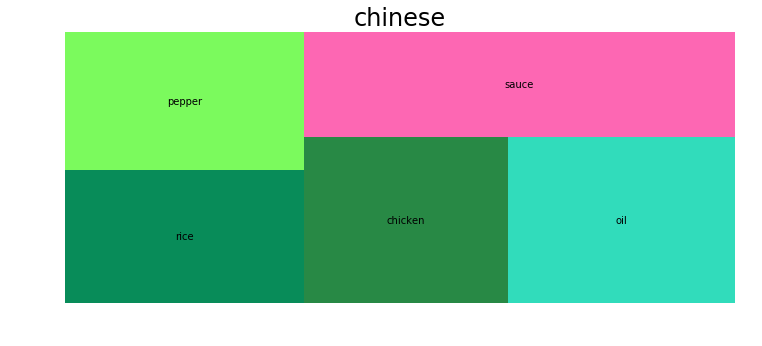

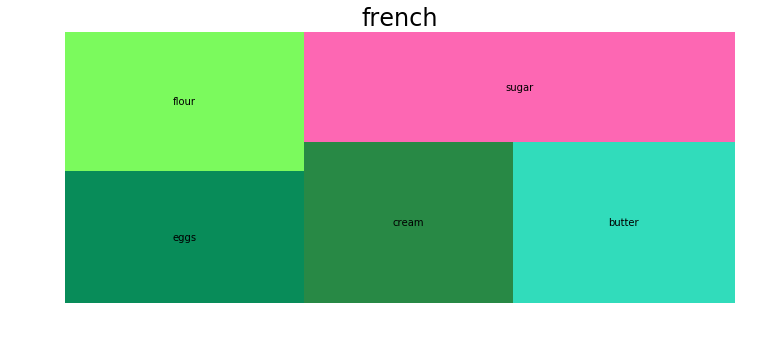

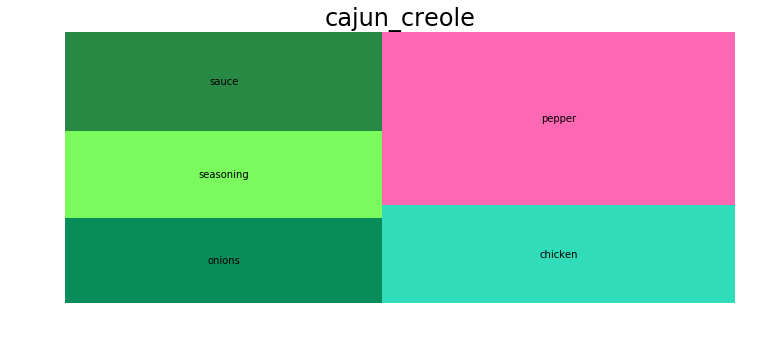

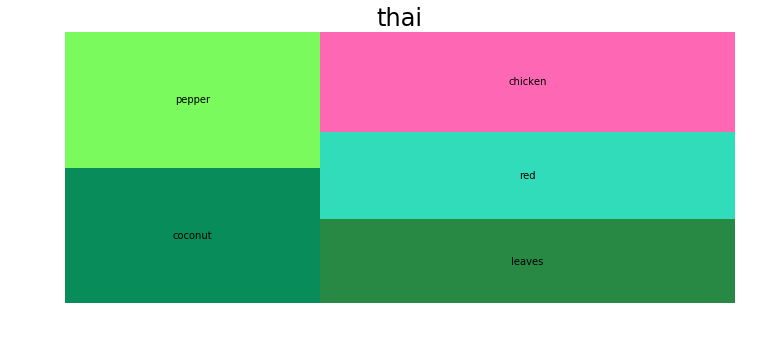

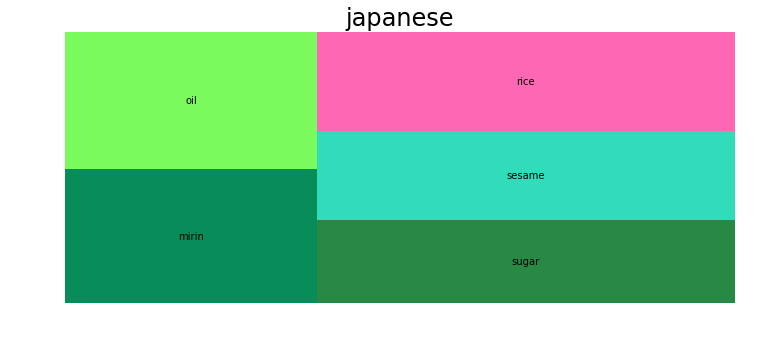

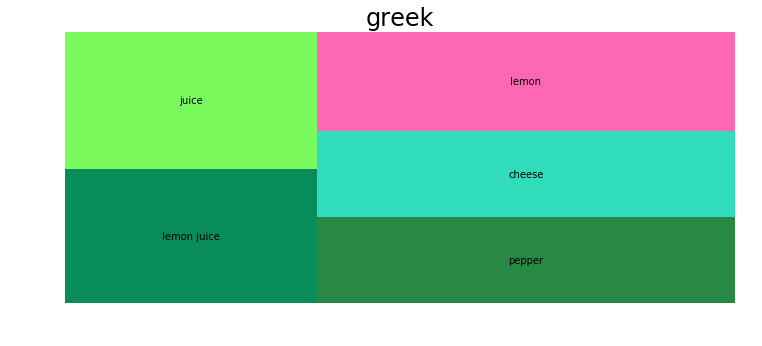

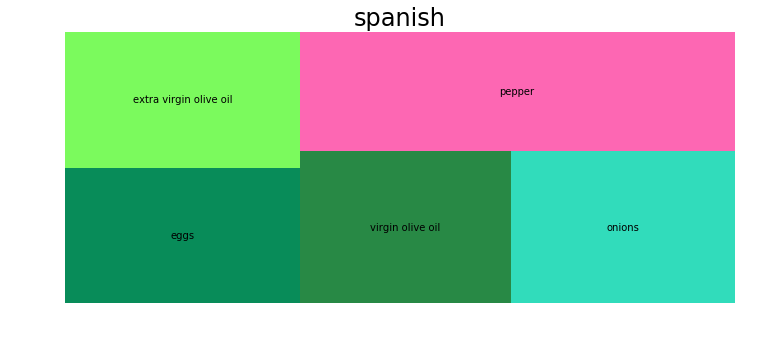

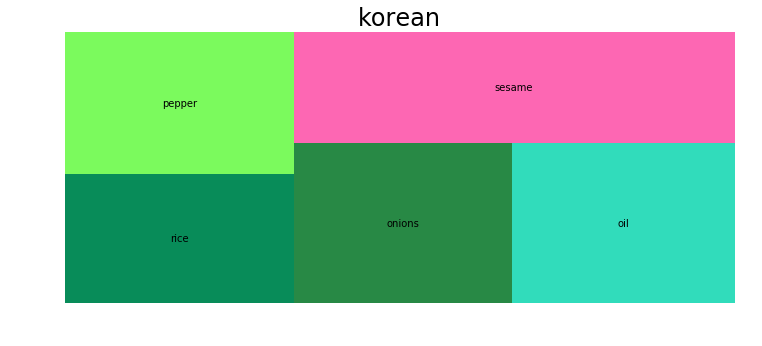

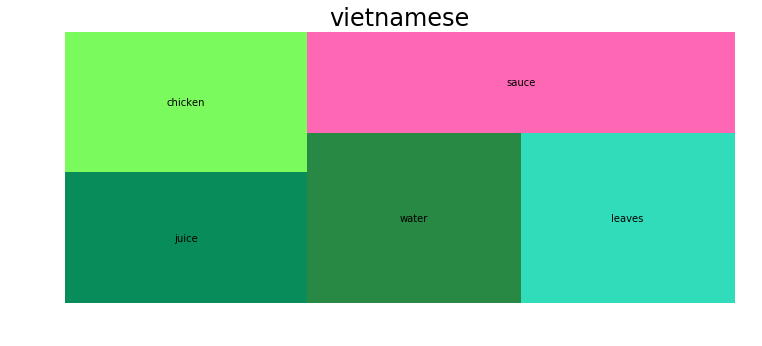

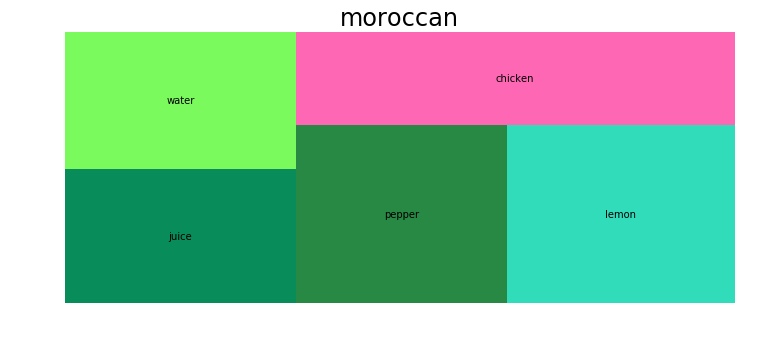

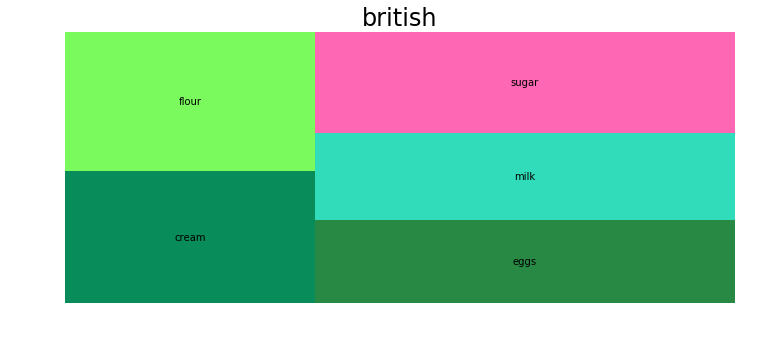

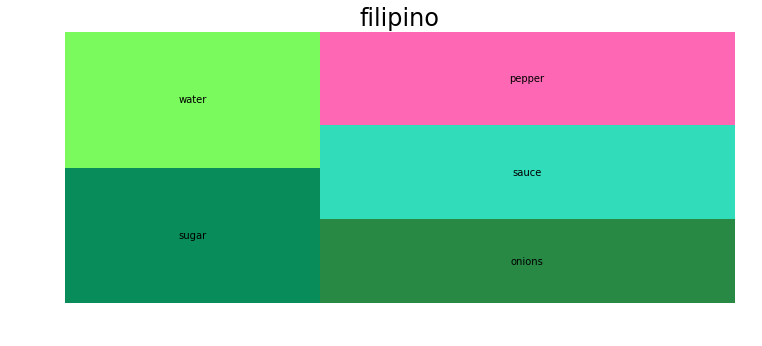

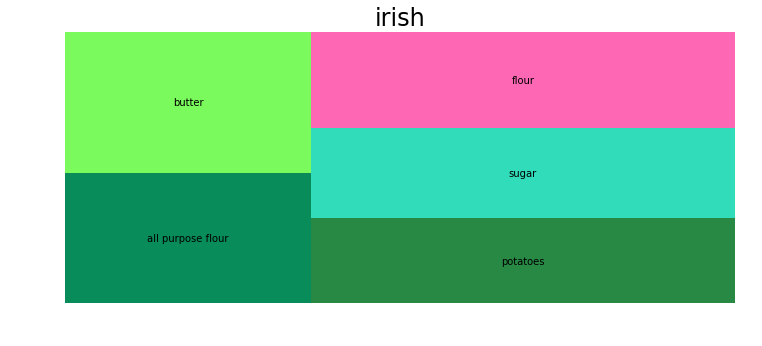

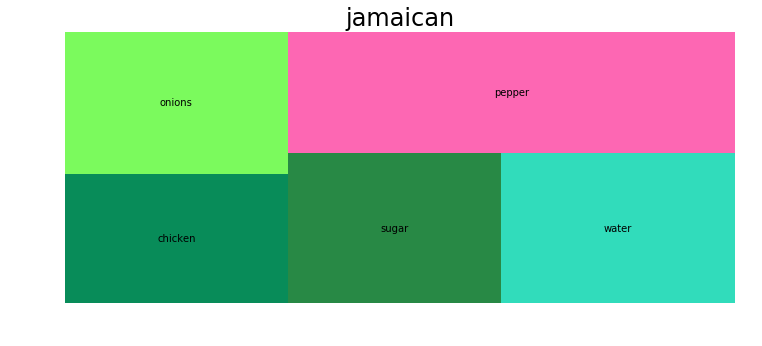

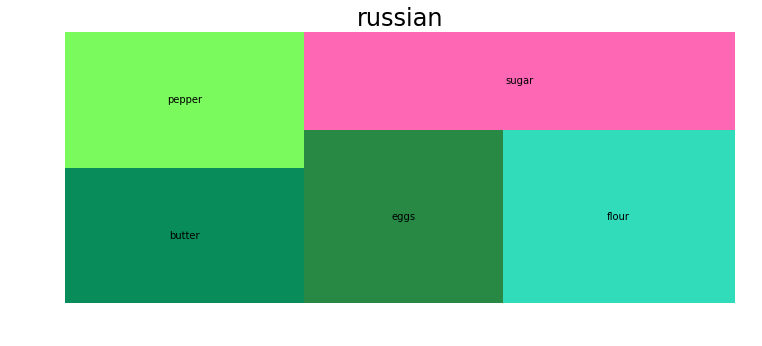

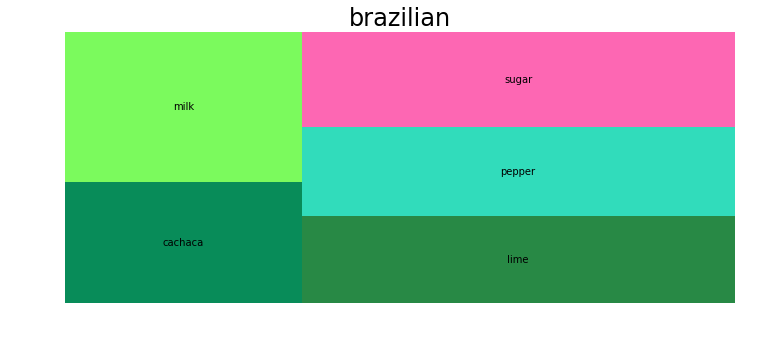

In [17]:
for i in range(len(labels)):

    ids = data['cuisine'] == labels[i]
    documents = data[ids].ingredients.values
    
    vocabulary = []
    for j in range(len(documents)):
        for k in range(len(documents[j])):
            vocabulary.append(documents[j][k])
    vocabulary = list(set(vocabulary))
    
    X = []
    for j in range(len(documents)):
        x = ''
        for k in (documents[j]):
            x += k + ' '
        X.append(x)
    
    tfidf_vectorizer = TfidfVectorizer(vocabulary= vocabulary, min_df=0.001, max_df=0.75, ngram_range=(1, 4))
    X = tfidf_vectorizer.fit_transform(X)
    
    word_tfidf = X.toarray()
    word_tfidf[word_tfidf < 0.1] = 0

    df = pd.DataFrame(data={'word': tfidf_vectorizer.get_feature_names(),
                            'tfidf': word_tfidf.sum(axis=0)
                           })
    
    top_5 = df.sort_values(['tfidf'], ascending=False).head(5)
    plt.figure(figsize=(12, 5))
    plt.title(labels[i])
    squarify.plot(label = top_5['word'][::-1], sizes = top_5['tfidf'][::-1], color=colors)
    plt.axis('off')
    plt.show()